# Running simulations with a field that is a function of time

The current api can be used to run simulations that have variable fields. By default, this variable field can be made to rotate in plane, or with a constant vertical component. However, these are only examples, and the field can really be any function of time. The strategy to do this is to modify the values of the field to use LAMMPS variables. The documentation for the functions that can be used with LAMMPS variables can be found in [https://docs.lammps.org/variable.html](https://docs.lammps.org/variable.html). 

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

sys.path.insert(0, '../../../../icenumerics/')
import icenumerics as ice

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [2]:
mpl.rc('text', usetex=True)
mpl.rcParams['figure.dpi'] = 150

## Define simulations

To do this, we need first to define a simulation as if we are going to run it with a constant system. Note that in the last step we are using the method `simulation` instead of `simulate`. This is because we don't want to run the simulation just yet. 

In [3]:
sp = ice.spins()

S = 4*ureg.um
R = 1*ureg.um
total_time = 60*ureg.s

L = S+4*(R+.5*ureg.um)*np.cos(np.pi/4)
N = 10
sp.create_lattice("square",[N,N],lattice_constant=L, border="periodic")

In [4]:
particle = ice.particle(radius = R,
             susceptibility = 0.0576,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = S,
               height = 4*ureg.pN*ureg.nm,
               stiffness = 1e-3*ureg.pN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap, 
                        height_spread = 0, susceptibility_spread = 0.1,
                        periodic = True)
col.randomize()
col.region = np.array([[0,0,-3*(R/L/N).magnitude],[1,1,3*(R/L/N).magnitude]])*N*L

world = ice.world(
    field = 1*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)

col.simulation(world,
             name = "test",
             include_timestamp = False,
             targetdir = r".",
             framerate = 10*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = total_time,
             output = ["x","y","z","mux","muy","muz"])

If we look at the components of the field, we see that they are defined as functions of other variables `v_Bmag`, `v_theta`, `time` and `v_phi`. This is done to implement the default conical rotating field. 

In [5]:
print(col.sim.field.fieldx)
print(col.sim.field.fieldz)

v_Bmag*cos(v_freq*time*2*PI+v_phi)*sin(v_theta)
v_Bmag*cos(v_theta)


We can use these functions, especially `v_Bmag` and `time` to define our version of the field. Note here that `time` doesn't have a `v_` before it. This is because it is an internal variable of lammps. As such, we must be careful because it is in $\mu{} s$

Using `v_Bmag` is useful because it is converted internally from $\mathrm{mT}$ to the units of the simulations (which are non standard). This value corresponds to whatever is given as the parameter `field`to the `world` object.

For example: we can apply a ramped field for a time (let's say 10 seconds) and then apply a constant field. All in plane components will be zero. The ramped field should go up to 1, and then stay constant there. This can be achieved by the function:

In [6]:
col.sim.field.fieldx = "0"
col.sim.field.fieldy = "0"
col.sim.field.fieldz = "v_Bmag/10e6*time*(time<10e6)+v_Bmag*(time>=10e6)"

After we do this, we can run the simulation:

In [7]:
col.run_simulation()

### We can also load the simulation to check

In [8]:
col.load_simulation()

in this case, we can take advantage of the moments written to the output files to obtain the shape of the field in time

In [9]:
col.trj.head()

type          x    y    z  mux  muy  muz    t
frame id                                               
0     1      1   2.121320  0.0  0.0  0.0  0.0  0.0  0.0
      2      1  10.364000  0.0  0.0  0.0  0.0  0.0  0.0
      3      1  18.606600  0.0  0.0  0.0  0.0  0.0  0.0
      4      1  26.849199  0.0  0.0  0.0  0.0  0.0  0.0
      5      1  39.091900  0.0  0.0  0.0  0.0  0.0  0.0

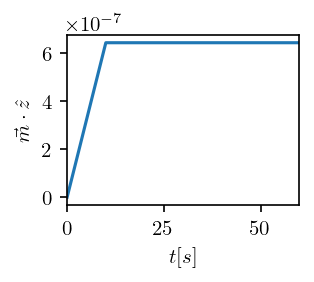

In [10]:
plt.figure(figsize=(2,1.5))
plt.plot(col.trj.loc[idx[:,1],"t"],col.trj.loc[idx[:,1],"muz"])
plt.xlim(-.1,60)
plt.xlabel(r"$t [s]$")
plt.ylabel(r"$\vec{m}\cdot\hat{z}$");